## Mutable Content Model
### Examples work in progress

A example PDF with some characters on the page across multiple nested forms.


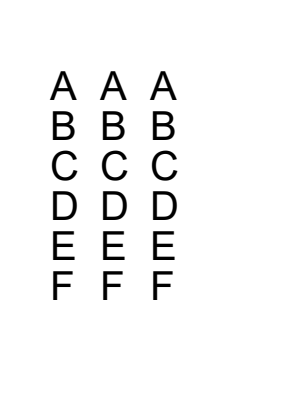

In [41]:
#!import "setup.ipynb"

using PdfLexer.Writing;

var doc = PdfDocument.Create();
var pg = doc.AddPage(300, 400);
{

    var f1 = new FormWriter();
    f1.Font(Base14.Helvetica, 40)
        .Text("A")
        .NewLine()
        .Text("B")
        .TextShift(0, -40)
        .Text("C")
        .NewLine()
        .Text("D")
        .ResetText()
        .Translate(0, -160)
        .Text("E")
        .NewLine()
        .Text("F");
    var form = f1.Complete();

    var f2 = new FormWriter();
    f2.Font(Base14.Helvetica, 40)
        .Translate(50, 0)
        .Save()
        .Text("A")
        .NewLine()
        .Text("B")
        .TextShift(0, -40)
        .Text("C")
        .NewLine()
        .Text("D")
        .ResetText()
        .Translate(0, -160)
        .Text("E")
        .NewLine()
        .Text("F")
        .Restore()
        .Translate(50, 0)
        .Form(form);
    var form2 = f2.Complete();

    using var writer = pg.GetWriter();
    writer.Font(Base14.Helvetica, 40)
        .Save()
        .Translate(50, 300)
        .Text("A")
        .NewLine()
        .Text("B")
        .TextShift(0, -40)
        .Text("C")
        .NewLine()
        .Text("D")
        .ResetText()
        .Translate(0, -160)
        .Text("E")
        .NewLine()
        .Text("F")
        .Restore()
        .Translate(50, 300)
        .Form(form2);
}

display(pg);



Page content can be parsed into the mutable model using `PdfPage.GetContentModel()`. The method accepts a boolean to flatten forms (default false). Form flattening can have adverse side effects in some advanced scenarios (mainly with transparency group handling) when rewriting the content to anotehr page so if you are using this make sure to test your use case. When form flattening is true any referenced forms on the page will be parsed into content groups as well and merged into the main content as a single list.

In [42]:
using PdfLexer.Writing;
using PdfLexer.Content.Model;
{
    var model = pg.GetContentModel();

    display(model.First().Type);
}

Text

There are currently five types of content.
- Text - Can be thought of as a paragraph although usually turns out to be much less when parsed from a PDF. Represents a grouping of characters starting at a consistent `text line matrix`.
- Paths - A vector path or paths terminated with a single drawing operation.
- Image - A rasterized image, either XObject or Inline. Note: Inline images are converted to XObject images when parsed into the mutable content model.
- Form - A XObject form. If form flattening is true these will not be returned.
- Shading - A PDF shading drawing operation.


### CachedContentMutation
A helper class `CachedContentMutation` is provided to facilitate modifying PDF page content more easily and perfomantly. This `CachedContentMutation` class handles nested form parsing and if a form is seen repeatedly (potentially across multiple pages) the `CachedContentMutation` will cache results to prevent duplicate parsing / modification.


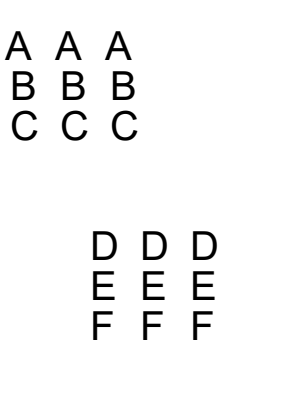

In [43]:
{
    var mutation = new CachedContentMutation(f => { 
            // can pattern match and use content type specific information (eg. text contents)
            if (f is TextContent<double> txt && txt.EnumerateCharacters().Any(x=> x.Char == 'A')) {
                f.Transform(new GfxMatrix<double> { E = -45, F = 40 });
                return f;
            }

            // other operations can be performed on any content type
            var bb = f.GetBoundingBox();
            if (bb.LLy > 200) {
                f.Transform(new GfxMatrix<double> { E = -40, F = 40 });
            } else {
                f.Transform(new GfxMatrix<double> { E = 40, F = -40 });
            }
            return f; 
        });

    var pg2 = mutation.Apply(pg);


    display(pg2);
}

### Example Copy / Paste




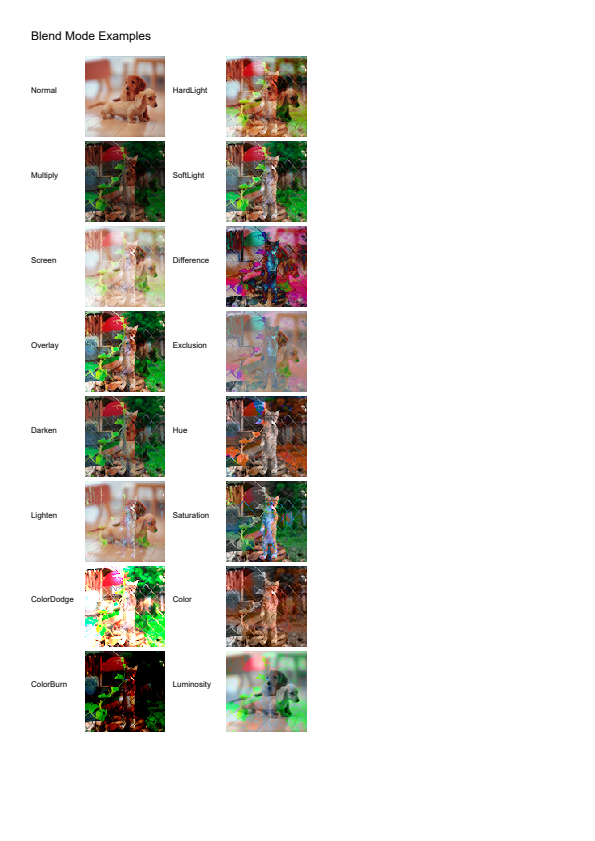

Total length: 3478


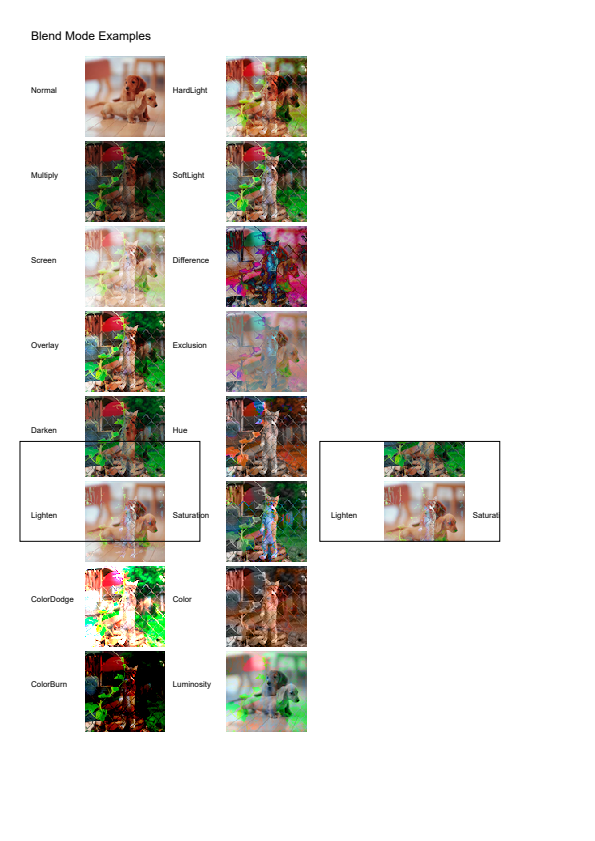

Total length: 4177

In [44]:
{
    using var doc = PdfDocument.Open(GetPdf("blendmode.pdf"));
    var page = doc.Pages[0];
    display(page);
    display("Total length: " + page.DumpDecodedContents().Length);

    // copy from here
    var area = new PdfRect<double>(20, 300, 200, 400);

    var mutation = new CachedContentMutation(f => { 

        return f.CopyArea(area);
    });

    var content = page.GetContentModel();
    content = mutation.Apply(content);
    {
        using var pw = page.GetWriter();
        pw.AddContent(content.Shift(300, 0)) // add shifted over
          .Rect(area) // draw source rect
          .Stroke()
          .Rect(320, 300, 180, 100) // draw dest rect
          .Stroke(); 
    }
    
    display(page);
    display("Total length: " + page.DumpDecodedContents().Length); // notice length did not increase substantially because
                                                                   // only the copied area was redrawn

}